In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.circuit.library import ZGate, XGate
from qiskit import execute, Aer
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np

In [2]:
def createSFblock(N, j):
    
    circuit = QuantumCircuit(N)
    
    state_decimal = format(j, '0'+str(N)+'b')[::-1] # inverse order due to Qiskit order: |q1q0>
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    multiConrolledZ = ZGate().control(num_ctrl_qubits=N-1)
    circuit.append(multiConrolledZ, range(N))
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    return circuit


In [3]:
def U_i(N, ki, circuit):
    
    # create equal superposition
    circuit.h(range(N))
    
    # apply SF blocks according to ki information
    vector_i = format(ki, '0'+str(2**N)+'b')
    for ij in range(len(vector_i)):
        if vector_i[ij] == '1': # n_j = 1, equivalent of having -1 in vector i
            circuit.compose(createSFblock(N, ij), inplace=True)  # the state i is the one that must have the phase of -1

def U_w(N, kw, circuit):
    
    # apply SF blocks according to kw information
    vector_w = format(kw, '0'+str(2**N)+'b')
    for wj in range(len(vector_w)):
        if vector_w[wj] == '1': # n_j = 1, equivalent of having -1 in vector w
            circuit.compose(createSFblock(N, wj), inplace=True)  # the state w is the one that must have the phase of -1
    
    # apply Hadamards
    circuit.h(range(N))
    
    # apply NOTs
    circuit.x(range(N))

In [4]:
def perceptron_brute_force(N, ki, kw, draw=False):
    
    # create circuit, N qubits + ancilla
    circuit = QuantumCircuit(N + 1, 1)
    
    # apply U_i
    U_i(N, ki, circuit)
    
    # apply U_w
    U_w(N, kw, circuit)
    
    # apply C^N X
    circuit.mcx(control_qubits=[i for i in range(N)], target_qubit=N)
    
    # measure the ancilla qubit
    circuit.measure(N, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

In [5]:
def draw_image(N, k):
        
    ns = format(k, '0'+str(2**N)+'b')
    
    fig, ax = plt.subplots(figsize=(2, 2))
        
    ax.grid(which='both', axis='both', linestyle='-', color='black', linewidth=1)

    cmap = colors.ListedColormap(['white', 'black'])

    ax.set_xticks(np.arange(0.5, N, 1));
    ax.set_yticks(np.arange(0.5, N, 1));
    plt.tick_params(axis='both', which='both', bottom=False,   
                    left=False, labelbottom=False, labelleft=False)
    
    image_data = np.zeros((N, N))
    j = 0
    for (x,y), _ in np.ndenumerate(image_data):
        image_data[x][y] = int(ns[j])
        j += 1
    
    ax.imshow(image_data, cmap=cmap)
    
    plt.show()

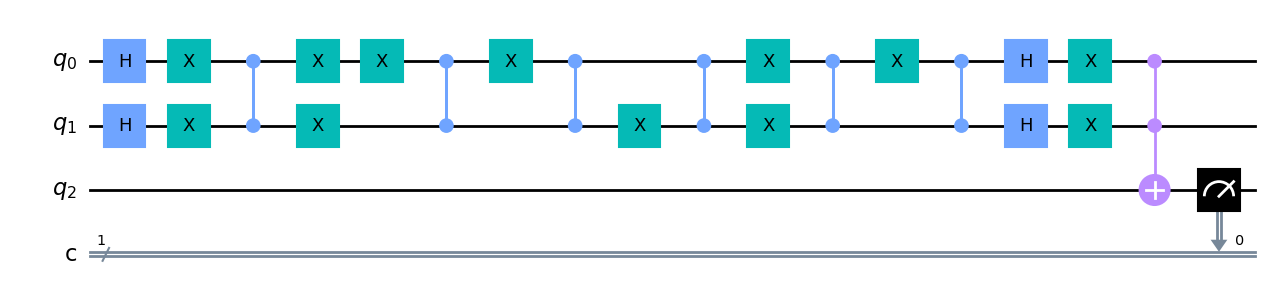

In [6]:
N=2
perceptron_circuit = perceptron_brute_force(N=N, ki=11, kw=7, draw=True) # equivalent to circuit in Fig 3c

In [7]:
perceptron_circuit.remove_final_measurements()
full_state = Statevector(perceptron_circuit)
print(full_state.data)

[-3.25176795e-17+0.j -1.00000000e+00+0.j -5.97792087e-34+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j -6.22328532e-19+0.j]


In [8]:
partial_density_matrix_ancilla = partial_trace(full_state, range(N))
partial_statevector_ancilla = partial_density_matrix_ancilla.to_statevector()
print(partial_statevector_ancilla.data)

print('probability of activation:', abs(partial_statevector_ancilla.data[1])**2)

[1.+0.j 0.+0.j]
probability of activation: 0.0


In [9]:
# Calculate for every value for ki and kw

N = 2

results = []
for kw in range(2**(2**N)):
    results.append([])
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_brute_force(N, ki, kw)
        perceptron_circuit.remove_final_measurements()
        full_state = Statevector(perceptron_circuit)
        partial_density_matrix_ancilla = partial_trace(full_state, range(N))
        results[kw].append(abs(partial_density_matrix_ancilla.data[1][1]))

In [10]:
# code from: https://stackoverflow.com/a/43119180/713780

def make_bar(ax, x0=0, y0=0, width = 0.5, height=1 , cmap="viridis",  
              norm=colors.Normalize(vmin=0, vmax=1), **kwargs ):
    # Make data
    u = np.linspace(0, 2*np.pi, 4+1)+np.pi/4.
    v_ = np.linspace(np.pi/4., 3./4*np.pi, 100)
    v = np.linspace(0, np.pi, len(v_)+2 )
    v[0] = 0 ;  v[-1] = np.pi; v[1:-1] = v_
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    xthr = np.sin(np.pi/4.)**2 ;  zthr = np.sin(np.pi/4.)
    x[x > xthr] = xthr; x[x < -xthr] = -xthr
    y[y > xthr] = xthr; y[y < -xthr] = -xthr
    z[z > zthr] = zthr  ; z[z < -zthr] = -zthr

    x *= 1./xthr*width; y *= 1./xthr*width
    z += zthr
    z *= height/(2.*zthr)
    #translate
    x += x0; y += y0
    #plot
    ax.plot_surface(x, y, z, cmap=cmap, norm=norm, **kwargs)

def make_bars(ax, x, y, height, width=1):
    widths = np.array(width)*np.ones_like(x)
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    h = np.array(height).flatten()
    w = np.array(widths).flatten()
    norm = colors.Normalize(vmin=0, vmax=1) #, vmax=h.max())
    for i in range(len(x.flatten())):
        make_bar(ax, x0=x[i], y0=y[i], width = w[i] , height=h[i], norm=norm)


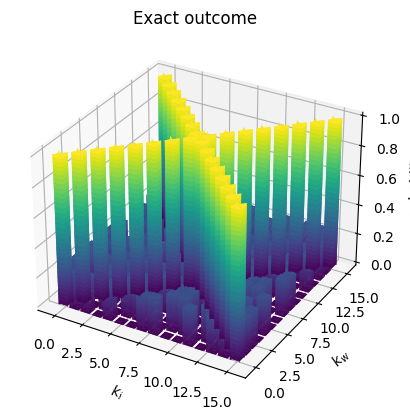

In [11]:
data_array = np.array(results) # Convert it into an numpy array


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

make_bars(ax, x_data, y_data, z_data, width=0.4)

ax.set_title("Exact outcome")
ax.set_xlabel('$k_i$')
ax.set_ylabel('$k_w$')
ax.set_zlabel('probability')

plt.show()

In [12]:
# save data 'cause take approx 6 hours to run on the cloud device
with open("results_exact_Ui_Uw.txt", "w") as file:
    file.write(str(results))

In [13]:
# with open("results_exact_Ui_Uw.txt", "r") as file:
#     results = eval(file.readline())

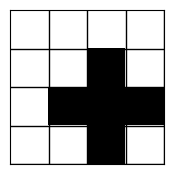

In [14]:
# weight vector for example for N=4 (Fig 4)
draw_image(N=4, k=626)

In [15]:
# examples as in Fig 4

kis = [624, 64941, 578, 64925, 49224, 15871, 37120, 34882]

kw = 626

In [16]:
def get_exact_probability_of_activation(N, ki, kw):
    perceptron_circuit = perceptron_brute_force(N=N, ki=ki, kw=kw)
    perceptron_circuit.remove_final_measurements()
    full_state = Statevector(perceptron_circuit)
    partial_density_matrix_ancilla = partial_trace(full_state, range(N))
    return abs(partial_density_matrix_ancilla.data[1][1])

exact = 0.7656249999999982


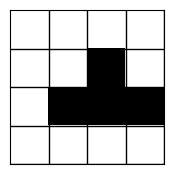

exact = 0.7656249999999982


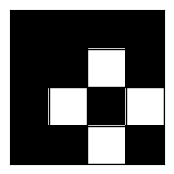

exact = 0.5624999999999987


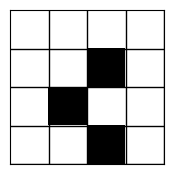

exact = 0.7656249999999982


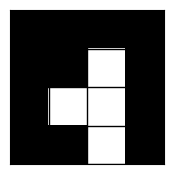

exact = 0.015624999999999962


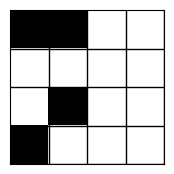

exact = 0.06249999999999986


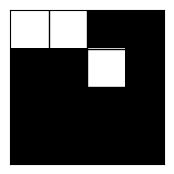

exact = 7.82596944164107e-34


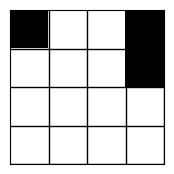

exact = 0.14062499999999967


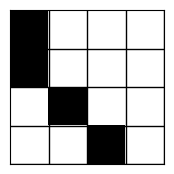

In [18]:
N=4
for ki in kis:
    prob = get_exact_probability_of_activation(N, ki, kw)
    print("exact =", prob)
    draw_image(N=N, k=ki)